# Simulation and inference of degree-corrected Poisson RGG

$$P(G|D, \theta, k) = \prod_{i<j} \frac{(k_i k_j \mathcal{F}(D_{ij}, \theta))^{A_{ij}}}{A_{ij}!} \exp(- k_i k_j \mathcal{F}(D_{ij}, \theta))$$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../utils')

In [3]:
from graphs import (get_independent_components_rgg, make_inter_vertex_distances, 
                    deg_corrected_poissonian_random_geometric_graph)
from plot import plot_multigraph
from networkx.linalg.graphmatrix import adjacency_matrix
import pymc3 as pm
import theano
import theano.tensor as tt
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
SEED = 42

In [5]:
n = 10
dim = 2

Choose

$$\mathcal{F}(D_{ij}, \theta)) = \lambda_0 e^{-\lambda_r D_{ij}}$$

so

$$P(G|D, \theta, k) = \prod_{i<j} \frac{(k_i k_j  \lambda_0 e^{-\lambda_r D_{ij}} )^{A_{ij}}}{A_{ij}!} \exp(- k_i k_j  \lambda_0 e^{-\lambda_r D_{ij}})$$

In [6]:
lambda_r_truth = 2
lambda_0_truth = 1
exponential_kernel = lambda dist, ki, kj: ki * kj * lambda_0_truth * math.exp(-lambda_r_truth * dist)

In [7]:
ki = np.ones(n)
ki[0] = 10

In [8]:
r = np.random.RandomState(SEED)
G_poisson = deg_corrected_poissonian_random_geometric_graph(
    n, 1000, ki, exponential_kernel, r, 
)

In [9]:
adj = adjacency_matrix(G_poisson)
adj = adj.toarray()

In [10]:
adj

array([[0, 2, 2, 3, 5, 4, 1, 3, 9, 1],
       [2, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [2, 0, 0, 1, 0, 0, 1, 2, 0, 0],
       [3, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [5, 0, 0, 1, 0, 0, 1, 0, 1, 0],
       [4, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [3, 0, 2, 0, 0, 0, 0, 0, 1, 0],
       [9, 0, 0, 0, 1, 0, 0, 1, 0, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 0]])

In [11]:
assert np.allclose(adj, adj.T)

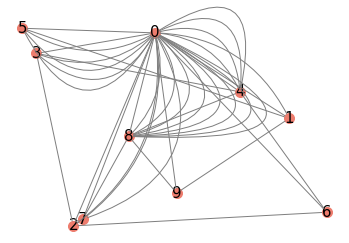

In [12]:
ax = plot_multigraph(G_poisson)

## Parsing

In [13]:
distances = make_inter_vertex_distances(G_poisson)
distances_filter,  adj_filter = get_independent_components_rgg(G_poisson, distances)

## Inference

Reminder: 

$$P(G|D, \theta, k) = \prod_{i<j} \frac{(k_i k_j  \lambda_0 e^{-\lambda_r D_{ij}} )^{A_{ij}}}{A_{ij}!} \exp(- k_i k_j  \lambda_0 e^{-\lambda_r D_{ij}})$$

In [14]:
triu_node_i, triu_node_j = np.triu_indices_from(distances, k=1)

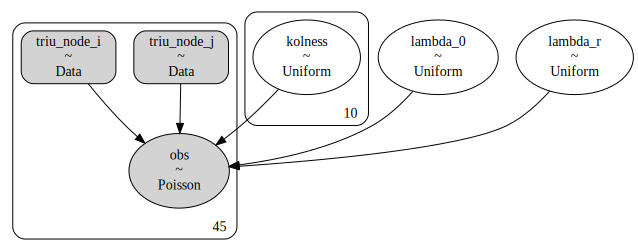

In [15]:
coords = {
    "node": np.arange(n),     
    "obs_id": np.arange(len(adj_filter))
}

distances_tt = theano.shared(distances)

with pm.Model(coords=coords) as poisson_rgg_model:    
    
    # not sure
    triu_node_i_tt = pm.Data("triu_node_i", triu_node_i, dims='obs_id')
    triu_node_j_tt = pm.Data("triu_node_j", triu_node_j, dims='obs_id')
    
    k = pm.Uniform("kolness", 0, 10, dims='node')
    
    
    d = distances_tt[triu_node_i_tt, triu_node_j_tt]          
    lambda_r = pm.Uniform('lambda_r', 0, 100)
    lambda_0 = pm.Uniform('lambda_0', 0, 100)
    
    mu = k[triu_node_i_tt] * k[triu_node_j_tt] * lambda_0 * pm.math.exp(-lambda_r * d)    
    
    obs = pm.Poisson('obs', mu=mu, observed=adj_filter)

pm.model_to_graphviz(poisson_rgg_model)    

In [16]:
with poisson_rgg_model:
    pooled_trace = pm.sample(draws=10000, random_seed=SEED, target_accept=0.9)
    pooled_idata = az.from_pymc3(pooled_trace)
az.summary(pooled_idata, round_to=2)

/home/juvid/miniconda3/envs/kolgraph_new/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_0, lambda_r, kolness]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 40 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kolness[0],8.89,1.00,7.04,10.00,0.01,0.00,20036.11,16866.48,1.0
kolness[1],1.30,0.76,0.20,2.68,0.01,0.00,16891.01,20860.62,1.0
kolness[2],2.16,1.10,0.48,4.17,0.01,0.01,16793.71,20877.87,1.0
kolness[3],1.42,0.82,0.24,2.93,0.01,0.00,14631.13,19700.05,1.0
kolness[4],2.09,1.09,0.41,4.06,0.01,0.01,12191.81,18432.34,1.0
kolness[5],1.60,0.92,0.26,3.25,0.01,0.01,13102.30,18937.67,1.0
kolness[6],1.67,1.07,0.20,3.58,0.01,0.01,20936.54,21707.76,1.0
kolness[7],2.01,1.04,0.42,3.89,0.01,0.01,16079.05,20317.70,1.0
kolness[8],3.17,1.45,0.96,5.99,0.01,0.01,11665.74,15770.55,1.0
kolness[9],0.98,0.60,0.12,2.08,0.00,0.00,18276.89,21110.61,1.0


In [17]:
lambda_r_truth, lambda_0_truth

(2, 1)

In [18]:
ki

array([10.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

array([[<AxesSubplot:title={'center':'kolness'}>,
        <AxesSubplot:title={'center':'kolness'}>],
       [<AxesSubplot:title={'center':'lambda_r'}>,
        <AxesSubplot:title={'center':'lambda_r'}>],
       [<AxesSubplot:title={'center':'lambda_0'}>,
        <AxesSubplot:title={'center':'lambda_0'}>]], dtype=object)

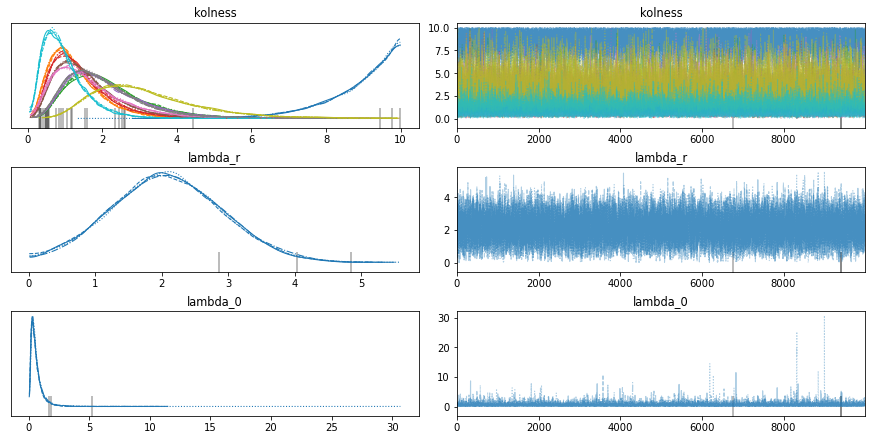

In [19]:
az.plot_trace(pooled_idata)

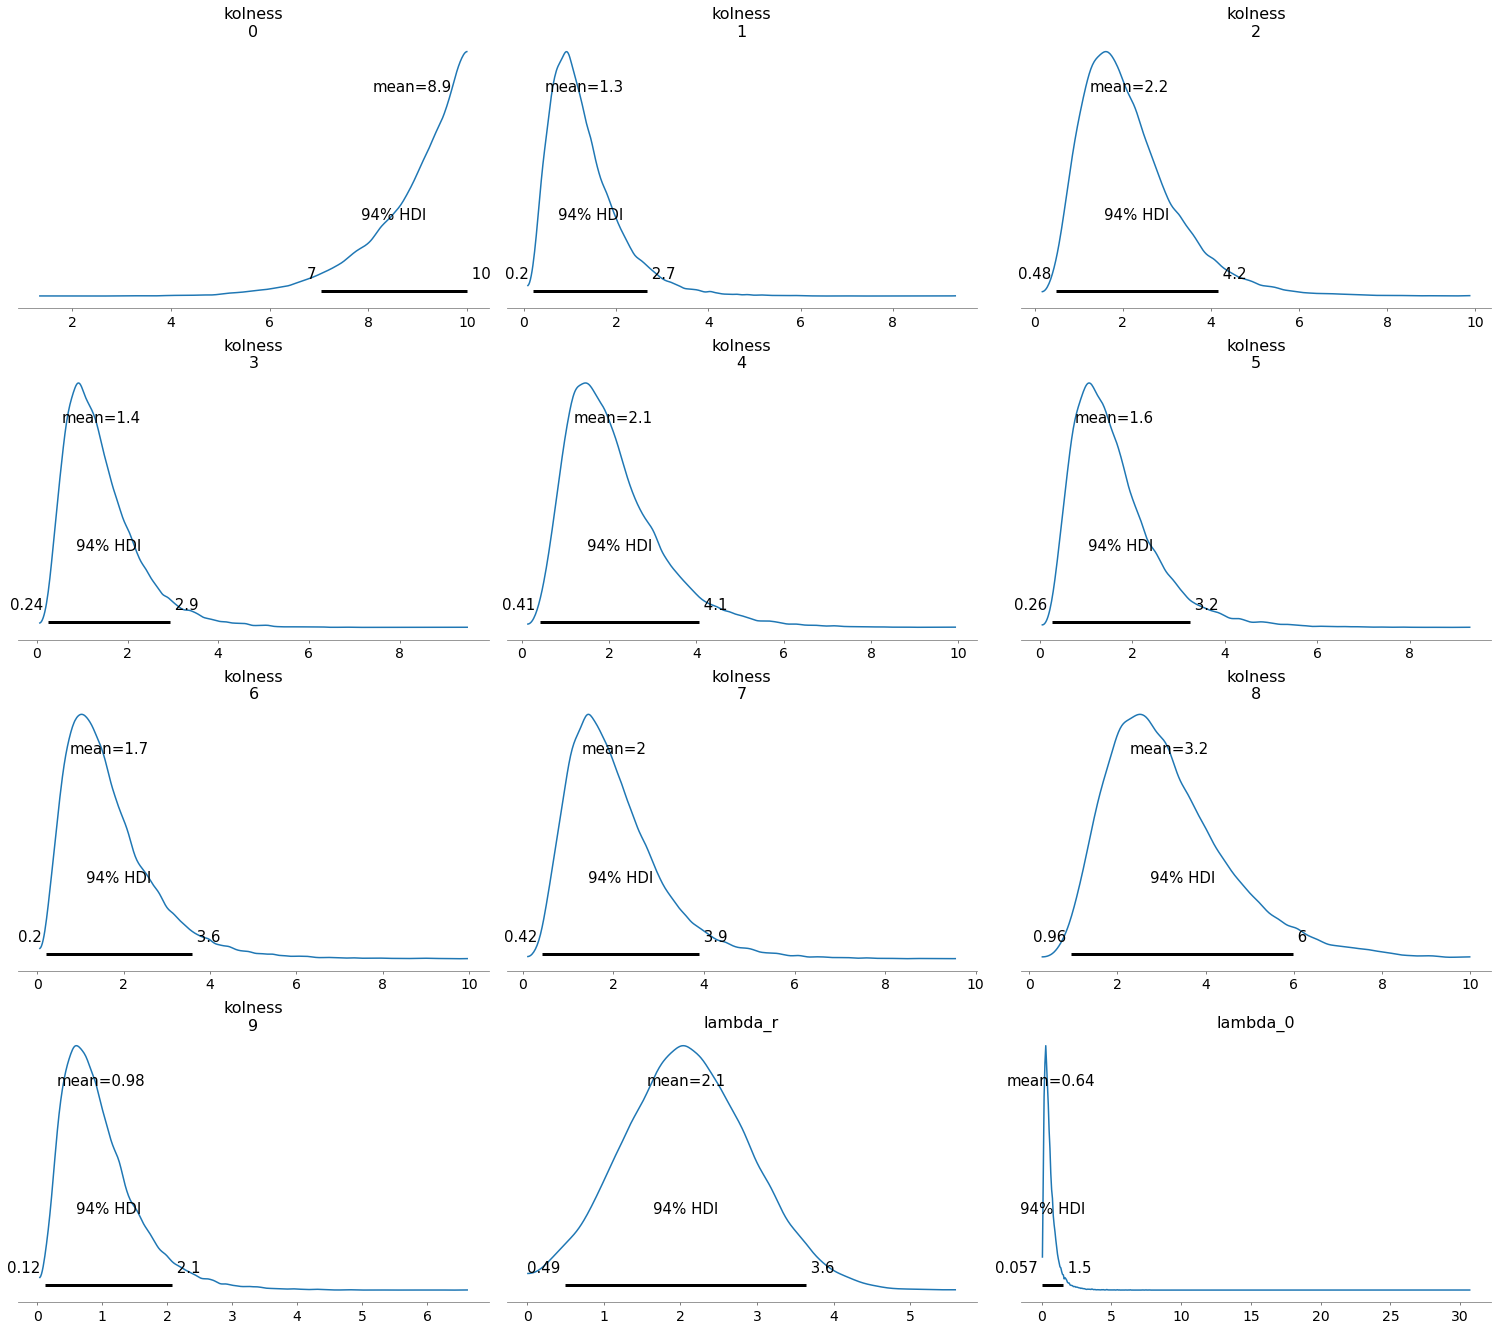

In [20]:
axs = az.plot_posterior(pooled_idata)